In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [3]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [4]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

In [5]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=100
nepochs=10

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU()
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 474.61it/s]

Training loss [0.8255228] Validation loss [0.6574618]
----New best validation loss---- [0.6574618]
Epoch 2



Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 465.23it/s]


Training loss [0.57905763] Validation loss [0.54817003]
----New best validation loss---- [0.54817003]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 459.17it/s]


Training loss [0.5365154] Validation loss [0.52416116]
----New best validation loss---- [0.52416116]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 447.36it/s]

Training loss [0.5143992] Validation loss [0.50605375]
----New best validation loss---- [0.50605375]
Epoch 5



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 449.25it/s]

Training loss [0.50074595] Validation loss [0.49946454]
----New best validation loss---- [0.49946454]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 450.97it/s]

Training loss [0.49090427] Validation loss [0.49050978]
----New best validation loss---- [0.49050978]
Epoch 7



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 441.86it/s]


Training loss [0.48250496] Validation loss [0.47858825]
----New best validation loss---- [0.47858825]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 443.02it/s]


Training loss [0.47516543] Validation loss [0.47299126]
----New best validation loss---- [0.47299126]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 452.35it/s]

Training loss [0.469867] Validation loss [0.4767306]
Epoch 10



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 444.73it/s]


Training loss [0.46513954] Validation loss [0.46171984]
----New best validation loss---- [0.46171984]
Best model out of total max epochs found at epoch 10


In [6]:
preds = model.predict(X_test.to_numpy())

In [7]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.005564146345595163

In [8]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

27.234905777477017

In [9]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.2167

## Visualise

In [10]:
X_test

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle
42726,1.211194,1.200976,1.000236,1.060977,0.770732,-0.117688,-0.002799,-0.269819,0.445337,0.082815,0.576733,0.642810,-1.606837,-0.957310,0.930441
1170,1.021849,0.984773,0.752274,0.835140,0.474800,-0.407726,-0.353598,-0.492502,0.856191,0.956313,-0.960624,-0.889151,-0.653708,-0.440238,-1.560845
14351,0.597259,0.563847,0.431252,0.679005,0.436296,-0.361020,-0.149523,-0.196199,0.499943,0.685518,-0.963521,-0.897313,1.451896,0.311313,1.133735
28608,1.302401,1.258230,0.985028,1.030747,0.743488,-0.033910,-0.035325,-0.125586,1.241165,1.174701,-1.002318,-0.951840,0.461951,-1.287709,-1.234522
32987,-0.356729,-0.363067,-0.324364,-0.463078,-0.310667,0.058801,0.035941,-0.106594,-0.009225,-0.013431,0.448433,0.096083,-1.048554,-0.157512,-0.034216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49754,0.169835,0.190563,0.235218,0.871448,0.873228,-0.024305,-0.098569,-0.148044,0.346005,-0.410058,0.205288,-0.069851,0.414303,0.020127,-1.606726
47481,0.143417,0.209366,0.209846,0.024815,0.314552,0.349789,0.228037,0.172974,-0.122447,-0.197743,-0.971220,-0.886231,0.815461,-1.559188,0.260186
24297,-0.131932,-0.182787,-0.327529,0.007178,-0.104526,-0.607867,-0.532325,-0.586048,-0.755242,-0.629316,0.130949,-0.066150,-1.335468,0.752204,-0.042725
4677,0.436960,0.413969,0.486050,0.448157,1.006249,0.064133,0.109323,-0.092963,0.233649,-0.433945,0.520002,0.473370,-0.507379,-0.117665,-1.666647


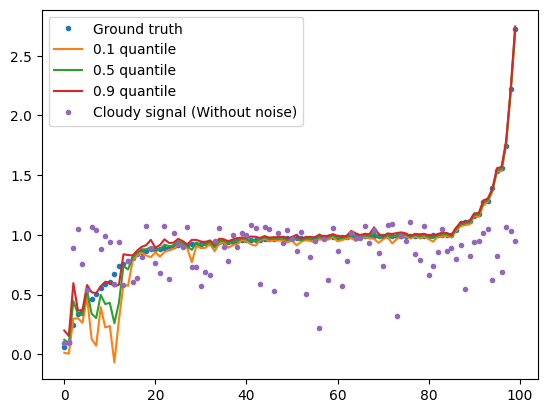

In [11]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


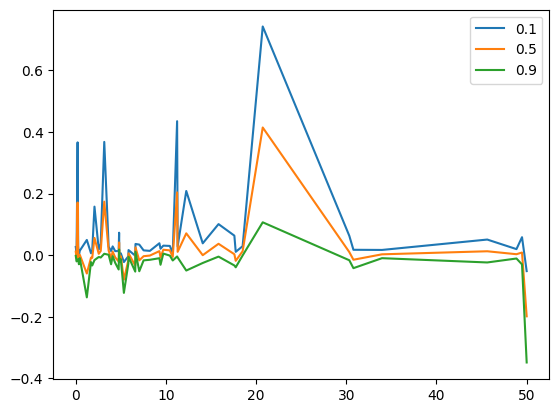

In [12]:
channel=5
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])